# Screamers: It is well known that WRITING IN ALL CAPS ONLINE IS A SUBSTITUTE FOR SCREAMING… OR YELLING. *cough!*. (Or some might say it’s simply cruise control for coooooooool). Write a job to find subreddits where users scream a lot, and provide a scream score (a highly-technical metric that you will invent) for the subreddits.

In [3]:
def get_subreddits_scream_score(file_dir):
    '''
    A wrapper function to get the scream score of subreddits
    
    Args:
      file_dir: A file path (string)
    '''
    df = spark.read.json(file_dir)
    df.createOrReplaceTempView("df_view")

    def map_find_scream_comments(s):
        '''
        A function to indicates which comments are "scream comments"
        
        Args:
            s: list of strings contains the subreddit name and the comment - (tuple)
        '''
        words = s[1].split(" ")

        count = 0
        for w in words:
            if count == 3:
                return (s[0], [1, 0])    
            if w.isupper():
                count += 1

        return (s[0], [0, 1])

    def map_calculate_scream_score(s):
        '''
        A function to calculate the scream score through this calculateion: 
        (#of_scream_comments / #total_comments) * 100
        
        Args:
            s: tuple of strings contains the subreddit name, #of_scream_comments, and #total_comments - (list)
            
        Returns:
            A tuple which contains subreddit name and the scream score
        '''
        return (s[0], s[1][0]/s[1][1] * 100)

    subreddit_scream_score = spark.sql("SELECT subreddit, body FROM df_view").rdd\
        .map(map_find_scream_comments)\
        .reduceByKey(lambda a,b:[a[0] +b[0], a[1] +b[1]])\
        .filter(lambda v: v[1][1] > 100)\
        .map(map_calculate_scream_score)
   
    print(subreddit_scream_score.takeOrdered(10, key = lambda x: -x[1]))
        

get_subreddits_scream_score('hdfs://orion11:23001/RC_2008-12.bz2')

[('SuicideWatch', 44.5945945945946), ('CommonLaw', 39.823008849557525), ('feminisms', 39.39393939393939), ('photography', 28.983688833124216), ('religiousdebate', 27.205882352941174), ('rpg', 26.08695652173913), ('Socialize', 25.520833333333332), ('WeAreTheMusicMakers', 24.801061007957557), ('Christianity', 23.076923076923077), ('iphone', 22.52252252252252)]


In this question, I used 2008 December reddit data. During that time, the top three subreddit that "Scream" the most are SuicideWatch, CommonLaw and feminisms.

# Readability: write a function that computes the Gunning Fog Index and Flesch-Kincaid Readability (both reading ease and grade level) of user comments. Then:
- Choose a subreddit and plot the distribution of these scores.
- Compare readability of two subreddits of your choosing. Analyze the results.


In [1]:
import syllables
import pandas as pd
import matplotlib.pyplot as plt

def map_calculate_gfi_fkr(s):
    '''
    A map function to calculate the GFI (Gunning Frog Index) and FKR (Flesch-Kincaid Readability)
    
    Args:
      s: tuple of strings contains the subreddit name and the comment - (tuple)

    Returns:
      A tuple which represent [subreddit, GFI, FKR, grade_level]
    '''
    words = s[1].split(" ") # Split sentence to list of words
    total_words = len(words)
    total_complex_words = 0
    total_sentences = 0
    total_syllables = 0
    
    i = 0
    for w in words:
        # Increment number of sentence when we encounter question mark, dot or exclamation mark or reach the end of the comment
        if len(w) > 0 and (w[-1] in ["?", ".", "!"] or i == total_words - 1):
            total_sentences += 1
        
        # Use syllables library to calculate number of syllables. This library prioritize speed over accuracy
        estimated_syllables = syllables.estimate(w)
        total_syllables += estimated_syllables
        
        # According to GFI a word is a complex word if the word contains 3 or more syllables
        if estimated_syllables >= 3:
            total_complex_words += 1
        i += 1

    gfi = 0
    fkr = 0
    # To make sure we do not get infinity number
    if total_sentences > 0 and total_words > 0:
        gfi = 0.4 * ((float(total_words)/total_sentences) + (100 * (float(total_complex_words)/total_words)))
        fkr = 206.835 - 1.015 * (float(total_words)/total_sentences) - 84.6 * (float(total_syllables)/total_words)

    # This logic below is used to get the grade based on FKR grade
    grade_level = ""
    if fkr > 90:
        grade_level = "5th grade"
    elif fkr > 80:
        grade_level = "6th grade"
    elif fkr > 70:
        grade_level = "7th grade"
    elif fkr > 60:
        grade_level = "8th and 9th grade"
    elif fkr > 50:
        grade_level = "10th to 12th grade"
    elif fkr > 30:
        grade_level = "college"
    elif fkr > 10:
        grade_level = "college graduate"
    else:
        grade_level = "professional"
    
    return (s[0], gfi, fkr, grade_level)
    
def plot_gfi(file_dir, subreddit_name, bin_number):
    '''
    This function call another function to calculate GFI and FKR score of a subreddit. Then, this function
    will plot a histogram to show the distribution of the subreddit
    
    Args:
      file_dir: A file path (string)
      subreddit_name: Subreddit name (string)
      bin_number: Number of bin for the histogram (int)
    '''
    df = spark.read.json(file_dir)
    df.createOrReplaceTempView("df_view")

    comment_gfi_fkr_score = spark.sql("SELECT subreddit, body FROM df_view").rdd\
        .map(map_calculate_gfi_fkr)\
        .filter(lambda v: v[1] > 0 and v[2] > 0 and v[2] <= 100)\
        .filter(lambda v: v[0] == subreddit_name)

    comment_gfi_fkr_score_df = comment_gfi_fkr_score.toDF(["subreddit", "gfi", "fkr", "grade_level"])
    comment_gfi_fkr_score_df = comment_gfi_fkr_score_df.toPandas()
    
    #define subplot layout
    x = comment_gfi_fkr_score_df['gfi']
    y = comment_gfi_fkr_score_df['fkr']
    plt.hist(x, bins=bin_number, alpha=0.5, label='gfi')
    plt.hist(y, bins=bin_number, alpha=0.5, label='fkr')
    plt.legend(loc='upper right')
    plt.show()

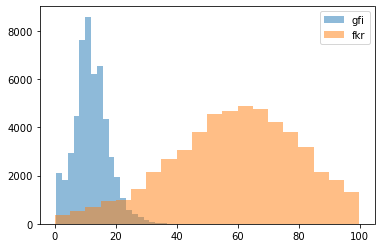

In [117]:
# Plot a GFI and FKR distribution of politic subreddit from 2008 December
plot_gfi('hdfs://orion11:23001/RC_2008-12.bz2', "politics", 20)

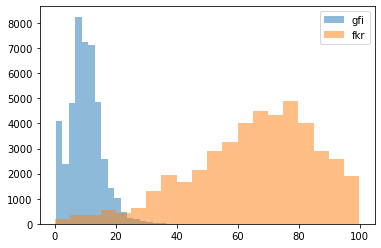

In [118]:
# Plot a GFI and FKR distribution of AskReddit subreddit from 2008 December
plot_gfi('hdfs://orion11:23001/RC_2008-12.bz2', "AskReddit", 20)

We can see that the distribution of the GFI (Gunning Frog Index) and FKR (Flesch-Kincaid Readability) are opposite to one another. This result is what we expected because the higher the GFI score, the more complex the sentence, but it is the opposite for the FKR score. In FKR, the higher the score means the less complex the sentence is.

In this assignment, the two subreddit that I picked are politics and AskReddit. AskReddit is a subreddit to ask and answer thought-provoking questions while politics subreddit is a is for news and discussion about U.S. politics. It is really interesting to see that the complexity of words in politics is higher compared to AskReddit from the graphs. Even though it says that AskReddit is a subreddit to ask and answer thought-provoking questions, when I checked the subreddit content, the majority of the questions are unimportant and do not require a lot of brain power. Some of the questions are: "If you had the ability to bring back a Canceled Series what would it be?", "What is the stupidest thing you believed in as a child?" and many others. While the politics subreddit contents are more serious. It contains news, politics discussion that requires more brain power/thoughts. In conclusion, I think this result is pretty accurate.

# Toxicity: write a function to perform Sentiment Analysis on comments. You can use a library to do this or roll your own (it’s not hard). Next, compare the toxicity between two subreddits of your choosing. Analyze the results.

In [2]:
import nltk
#nltk.download('vader_lexicon') # To download nltk if the user does not have it yet
from nltk.sentiment import SentimentIntensityAnalyzer

def map_sentiment_score(s):
    '''
    A map function to calculate the sentiment score of subreddit comments
    
    Args:
      s: a tuple of strings contains the subreddit name and the comment - (tuple)

    Returns:
      A tuple which contains -> (subreddit_name, [sentiment_score, 1])
    '''
    
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(s[1])['compound']
    return (s[0], [score, 1])

def map_calculate_sentiment_score_avg(s):
    '''
    A map function that calculates sentiment score average
    
    Args:
      s: a tuple contains subreddit_name, sentiment_score_total and total_comments

    Returns:
      A tuple which contains -> subreddit_name and sentiment score average
    '''
    
    return (s[0], s[1][0]/s[1][1])

def get_toxicity_score_subreddit(file_dir, subreddit_name):
    '''
    A function that calculates sentiment score of a subreddit
    
    Args:
      file_dir: file directory (string)
      subreddit_name: name of a subreddit (string)
    '''
    
    df = spark.read.json(file_dir)
    df.createOrReplaceTempView("df_view")

    toxicity_score = spark.sql("SELECT subreddit, body FROM df_view").rdd\
        .filter(lambda v: v[0] == subreddit_name)\
        .map(map_sentiment_score)\
        .reduceByKey(lambda a,b:[a[0] +b[0], a[1] +b[1]])\
        .map(map_calculate_sentiment_score_avg)

    print(toxicity_score.take(1))

In [23]:
# Calculate toxicity on religiousdebate subreddit
get_toxicity_score_subreddit("hdfs://orion11:23001/RC_2008-12.bz2", "religiousdebate")

[('religiousdebate', 0.14368063583815033)]


In [24]:
# Calculate toxicity on Christianity subreddit
get_toxicity_score_subreddit("hdfs://orion11:23001/RC_2008-12.bz2", "Christianity")

[('Christianity', 0.2803661931818182)]


For this question, the two subreddit that I analyzed are religiousdebate and Christianity. Based on the toxicity score average above, religiousdebate seems like more negative compared to christiniatiy. In my opinion this is make sense because religious debate can be intense as people with different religion gather together in a discussion board. As for christianity, I feel like it will be more positive even though the subreddit might contains some debate. Since most of the people in Christianity subreddit probably are christian, the debate probably more constructive and positive.

Further analysis can be seen below with the plot. Additionally, I would like to add that according to this website: https://towardsdatascience.com/the-best-python-sentiment-analysis-package-1-huge-common-mistake-d6da9ad6cdeb vader is not that great compared to flair. At first, I wanted to use flair, but it seems like the library requires a lot of spaces and I don't have enough spaces to download it on orion machine.

In [37]:
def map_reformat_data(s):
    '''
    A map function to reformat input value
    
    Args:
      s: a tuple contains -> (subreddit_name, [sentiment_value, 1])

    Returns:
      A tuple which contains -> (subreddit_name, sentiment_score, 1)
    '''
    
    return (s[0], s[1][0], s[1][1])

def plot_toxicity_score(file_dir, subreddit_name, bin_number):
    '''
    A function that create a plot for a subreddit based on the sentiment score
    
    Args:
      file_dir: file directory (string)
      subreddit_name: name of a subreddit (string)
      bin_number: the bin number for the histogram
    '''
    
    df = spark.read.json(file_dir)
    df.createOrReplaceTempView("df_view")

    toxicity_score = spark.sql("SELECT subreddit, body FROM df_view").rdd\
        .filter(lambda v: v[0] == subreddit_name)\
        .map(map_sentiment_score)\
        .map(map_reformat_data)
    
    toxicity_score_df = toxicity_score.toDF(["subreddit", "toxicity_score", "count"])
    toxicity_score_df = toxicity_score_df.toPandas()
    
    x = toxicity_score_df["toxicity_score"]
    plt.hist(x, bins=bin_number, alpha=0.5, label="toxicity_score")
    plt.show()

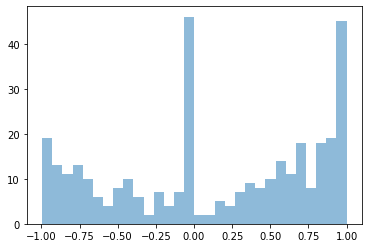

In [39]:
# Plot toxicity score on religiousdebate subreddit
plot_toxicity_score("hdfs://orion11:23001/RC_2008-12.bz2", "religiousdebate", 30)

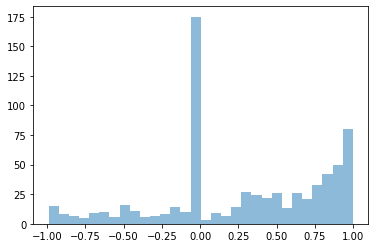

In [40]:
# Plot toxicity score on Christianity subreddit
plot_toxicity_score("hdfs://orion11:23001/RC_2008-12.bz2", "Christianity", 30)

Based on the charts aboe, it seems like my prediction before was wrong. The toxicity on both subreddits are almost the same. The amount of the worst comments are almost the same which is around 20-ish. However, it seems like there are more positive comments on Christianity compared to the religious debate.

# Targeted Advertising: given a specific user, find out more about them: where they’re from, what things they like/dislike, and other data about their background (think of at least 2 more things to determine). Note that this should be automated; I should be able to give you a username and you’ll produce a report for them. Provide three sample user reports that we can exploit to create ads they won’t be able to resist.

In [43]:
def show_top_twenty(file_dir):
    # Get top 20 subreddit
    df = spark.read.json(file_dir)
    df.createOrReplaceTempView("df_view")
    author_rdd = spark.sql("SELECT subreddit, author, author_fullname, body FROM df_view").show()
    
show_top_twenty("hdfs://orion11:23001/RES-RC_2020-12.zst")

+-------------------+-------------------+---------------+--------------------+
|          subreddit|             author|author_fullname|                body|
+-------------------+-------------------+---------------+--------------------+
|     wallstreetbets|indigoismyfavourite|       t2_noj88|        oof -10% gme|
|           kpophelp|           natthatt|    t2_22bikj41|it's not a 'tradi...|
|        The_Mueller|        novagenesis|       t2_27352|If Trump is pardo...|
|             WillNE|        killedtoast|    t2_5jo22z6o|     thats a classic|
|                wow|           DanLynch|       t2_7pmqs|The voice actor i...|
|            Sub4Sub|           cookbake|    t2_87q4ibfr|Done \n\nDo it to...|
|             Madden|       vikings12886|    t2_2nnf6ks3|    Unfortunately no|
|pointlesslygendered|    FlairoftheFlame|       t2_cqwfp|My handwriting go...|
|                nba|      Coffeeandsoda|    t2_7gdbl69f|Yes, but by sayin...|
|     PoliticalHumor|         eggsnflour|    t2_1yn7

In [3]:
from datetime import datetime

def map_calculate_sentiment_score_avg(s):
    '''
    A map function that calculates sentiment_score_average
    
    Args:
      s: a tuple contains -> (subreddit_name, [sentiment_value, 1])

    Returns:
      A tuple which contains -> (subreddit_name, sentiment_score_avg, 1)
    '''
    
    return (s[0], s[1][0]/s[1][1], s[1][1])

def convert_utc_to_local_time(s):
    '''
    A map function that gets the hour from unix utc formatted time
    
    Args:
      s: a tuple contains -> (unix_utc_time)

    Returns:
      A tuple which contains -> (hour, 1)
    '''
    
    hour_str = datetime.utcfromtimestamp(int(s[0])).strftime('%H')
    
    return (int(hour_str), 1)

def get_author_info(file_dir, author_id):
    '''
    A function that show the subreddit and the subreddit user response towards
    that subreddit. Additionally, this function also show a plot that shows
    the user active hours
    
    Args:
      file_dir: file directory (string)
      author_id: subreddit username (string)
    '''
    df = spark.read.json(file_dir)
    df.createOrReplaceTempView("df_view")

    author_info_query = "SELECT subreddit, body, created_utc FROM df_view WHERE author == '" + author_id + "'"
    author_info = spark.sql(author_info_query)
    author_info.cache()
    
    # Getting subreddits that the author participate in
    author_subreddits = author_info.select("subreddit","body").rdd\
        .map(map_sentiment_score)\
        .reduceByKey(lambda a,b:[a[0] +b[0], a[1] +b[1]])\
        .map(map_calculate_sentiment_score_avg)
    
    # Active time of the author
    author_active_time = author_info.select("created_utc").rdd\
        .map(convert_utc_to_local_time)\
        .reduceByKey(lambda a,b: a +b)
    
    print("author id: " + author_id)
    author_subreddits.toDF(["subreddit", "sentiment_score", "num_of_posts"]).show()
    
    print("author_active_time")
    author_active_time_df = author_active_time.toDF(["hour", "count"]).toPandas()
    
    x = author_active_time_df["hour"]
    y = author_active_time_df["count"]
    plt.bar(x, y)
    plt.xlabel('hours')
    plt.ylabel('frequency')
    plt.show()

author id: indigoismyfavourite
+--------------+--------------------+------------+
|     subreddit|     sentiment_score|num_of_posts|
+--------------+--------------------+------------+
|wallstreetbets|0.027624475524475518|         143|
|     investing|                 0.0|           2|
+--------------+--------------------+------------+

author_active_time


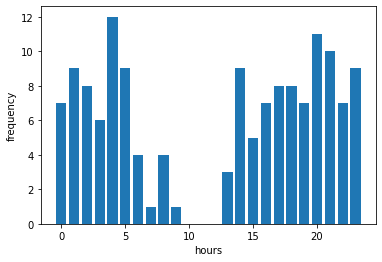

In [4]:
get_author_info("hdfs://orion11:23001/RES-RC_2020-12.zst", "indigoismyfavourite")

author id: Coffeeandsoda
+---------+-------------------+------------+
|subreddit|    sentiment_score|num_of_posts|
+---------+-------------------+------------+
|      nba|0.37411666666666665|          12|
| MkeBucks|            -0.0258|           1|
+---------+-------------------+------------+

author_active_time


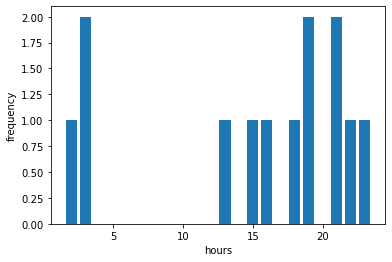

In [7]:
get_author_info("hdfs://orion11:23001/RES-RC_2020-12.zst", "Coffeeandsoda")

author id: eggsnflour
+-----------------+---------------+------------+
|        subreddit|sentiment_score|num_of_posts|
+-----------------+---------------+------------+
|   PoliticalHumor|            0.0|           2|
|    modernwarfare|            0.0|           1|
|      Cringetopia|            0.0|           1|
|     MakeMeSuffer|            0.0|           1|
|     2meirl4meirl|        -0.2617|           1|
|holdmyfeedingtube|        -0.3612|           1|
|     pcmasterrace|            0.0|           1|
|         StarWars|        -0.6908|           1|
+-----------------+---------------+------------+

author_active_time


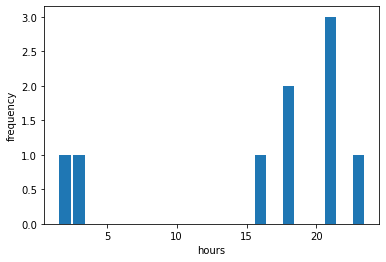

In [6]:
get_author_info("hdfs://orion11:23001/RES-RC_2020-12.zst", "eggsnflour")

For this question, I analyzed three reddit users: indigoismyfavourite, Coffeeandsoda, and eggsnflour. The most active users out of the three is indigoismyfavourite. It seems like he is interested to know about the stock market trends. He is pretty active as you can see that he has a total of 145 posts/comments on December 2020 alone.